# ✅ Install dependencies

In [ ]:
%pip install tensorflow numpy mediapipe opencv-python tensorflowjs pyautogui matplotlib seaborn scikit-learn ipython

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# ✅ Import library

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML

# ✅ Deteksi tangan dengan MediaPipe

In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# ✅ Ambil dan simpan data gesture

In [2]:


# Setup
DATA_DIR = "hand_data"
os.makedirs(DATA_DIR, exist_ok=True)

gestures = ["SS", "transfer_SS"]
num_sequences = 300              # Jumlah sequence per gesture
sequence_length = 10             # Jumlah frame per sequence

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)

for gesture_name in gestures:
    print(f"\nBersiap untuk merekam gesture: {gesture_name}")
    print("Tekan 's' untuk mulai merekam...")

    # Tunggu tombol 's' ditekan
    while True:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        cv2.putText(frame, f"Tekan 's' untuk mulai rekam {gesture_name}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow("Hand Tracking", frame)
        if cv2.waitKey(1) & 0xFF == ord('s'):
            break

    print(f"Merekam {num_sequences} sequence (tiap sequence {sequence_length} frame) untuk gesture: {gesture_name}")
    data, labels = [], []
    seq_count = 0

    while seq_count < num_sequences:
        sequence = []
        frame_valid = True

        for _ in range(sequence_length):
            ret, frame = cap.read()
            frame = cv2.flip(frame, 1)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = hands.process(rgb_frame)

            if result.multi_hand_landmarks:
                hand_landmarks = result.multi_hand_landmarks[0]
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                sequence.append(landmarks)

                # Gambar tangan
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            else:
                frame_valid = False
                break  # Jika 1 frame saja gagal, batalkan sequence ini

            cv2.putText(frame, f"{gesture_name} | Sequence: {seq_count + 1}/{num_sequences}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.imshow("Hand Tracking", frame)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                exit()

        if frame_valid:
            data.append(sequence)
            labels.append(gesture_name)
            seq_count += 1
            print(f"✓ Sequence {seq_count} terekam")

    # Simpan data
    np.save(os.path.join(DATA_DIR, f"{gesture_name}_data.npy"), np.array(data))       # shape: (300, 10, 63)
    np.save(os.path.join(DATA_DIR, f"{gesture_name}_labels.npy"), np.array(labels))   # shape: (300,)
    print(f"Selesai merekam {gesture_name}. Data disimpan.\n")

cap.release()
cv2.destroyAllWindows()



Bersiap untuk merekam gesture: SS
Tekan 's' untuk mulai merekam...
Merekam 300 sequence (tiap sequence 10 frame) untuk gesture: SS
✓ Sequence 1 terekam
✓ Sequence 2 terekam
✓ Sequence 3 terekam
✓ Sequence 4 terekam
✓ Sequence 5 terekam
✓ Sequence 6 terekam
✓ Sequence 7 terekam
✓ Sequence 8 terekam
✓ Sequence 9 terekam
✓ Sequence 10 terekam
✓ Sequence 11 terekam
✓ Sequence 12 terekam
✓ Sequence 13 terekam
✓ Sequence 14 terekam
✓ Sequence 15 terekam
✓ Sequence 16 terekam
✓ Sequence 17 terekam
✓ Sequence 18 terekam
✓ Sequence 19 terekam
✓ Sequence 20 terekam
✓ Sequence 21 terekam
✓ Sequence 22 terekam
✓ Sequence 23 terekam
✓ Sequence 24 terekam
✓ Sequence 25 terekam
✓ Sequence 26 terekam
✓ Sequence 27 terekam
✓ Sequence 28 terekam
✓ Sequence 29 terekam
✓ Sequence 30 terekam
✓ Sequence 31 terekam
✓ Sequence 32 terekam
✓ Sequence 33 terekam
✓ Sequence 34 terekam
✓ Sequence 35 terekam
✓ Sequence 36 terekam
✓ Sequence 37 terekam
✓ Sequence 38 terekam
✓ Sequence 39 terekam
✓ Sequence 40 terek

# ✅ Ekstraksi Koordinat

In [49]:
# Load data sequence masing-masing gesture
data_ss = np.load("hand_data/SS_data.npy")            # shape: (300, 10, 63)
data_tf = np.load("hand_data/transfer_SS_data.npy")

# Fungsi untuk menampilkan 1 sequence (10 frame) dari 1 sample
def tampilkan_vektor_sequence(data, nama_gesture, indeks_sample=0):
    print("="*50)
    print(f"🖐️  Gesture: {nama_gesture}")
    print(f"📐 Shape data: {data.shape}")
    print(f"📊 Jumlah sample   : {len(data)}")
    print(f"📹 Frame per sample: {data.shape[1]}")
    print(f"📎 Fitur per frame : {data.shape[2]}")
    print("="*50)
    
    print(f"\n📌 Menampilkan koordinat tangan dari sample ke-{indeks_sample}:\n")

    for frame_ke in range(data.shape[1]):
        print(f"🟩 Frame {frame_ke+1}/{data.shape[1]}:")
        vektor = data[indeks_sample][frame_ke]
        
        for i in range(21):
            x, y, z = vektor[i*3], vektor[i*3+1], vektor[i*3+2]
            print(f"   - Titik {i+1:02d}: x={x:.4f}, y={y:.4f}, z={z:.4f}")
        print("-" * 40)

# Contoh pemanggilan fungsi:
tampilkan_vektor_sequence(data_ss, "SS (Screenshot)", indeks_sample=0)
tampilkan_vektor_sequence(data_tf, "transfer_SS (Transfer File)", indeks_sample=0)


🖐️  Gesture: SS (Screenshot)
📐 Shape data: (300, 10, 63)
📊 Jumlah sample   : 300
📹 Frame per sample: 10
📎 Fitur per frame : 63

📌 Menampilkan koordinat tangan dari sample ke-0:

🟩 Frame 1/10:
   - Titik 01: x=0.6999, y=0.5715, z=-0.0000
   - Titik 02: x=0.6493, y=0.5773, z=-0.0059
   - Titik 03: x=0.5986, y=0.5463, z=-0.0143
   - Titik 04: x=0.5548, y=0.5398, z=-0.0256
   - Titik 05: x=0.5137, y=0.5401, z=-0.0361
   - Titik 06: x=0.6368, y=0.4162, z=0.0031
   - Titik 07: x=0.5860, y=0.3777, z=-0.0143
   - Titik 08: x=0.5410, y=0.3745, z=-0.0305
   - Titik 09: x=0.5059, y=0.3862, z=-0.0411
   - Titik 10: x=0.6446, y=0.4084, z=-0.0067
   - Titik 11: x=0.5816, y=0.3710, z=-0.0228
   - Titik 12: x=0.5327, y=0.3724, z=-0.0356
   - Titik 13: x=0.4969, y=0.3855, z=-0.0439
   - Titik 14: x=0.6493, y=0.4152, z=-0.0196
   - Titik 15: x=0.5844, y=0.3738, z=-0.0352
   - Titik 16: x=0.5368, y=0.3749, z=-0.0436
   - Titik 17: x=0.5024, y=0.3885, z=-0.0477
   - Titik 18: x=0.6476, y=0.4356, z=-0.0338

# ✅ Data augmentation functions

In [39]:
import os
import numpy as np

DATA_DIR = "hand_data"
AUGMENT_TIMES = 2  # Jumlah augmentasi per sequence (jadi total x3: original + 2 augmentasi)

gestures = ["SS", "transfer_SS"]

# Augmentasi: Jitter / Noise
def add_noise(sequence, noise_level=0.01):
    return sequence + np.random.normal(0, noise_level, sequence.shape)

# Augmentasi: Scale
def scale(sequence, scale_range=(0.9, 1.1)):
    scale_factor = np.random.uniform(*scale_range)
    return sequence * scale_factor

# Augmentasi: Translate / Shift
def translate(sequence, shift_range=0.1):
    shifts = np.random.uniform(-shift_range, shift_range, size=sequence.shape[1])
    return sequence + shifts

# (Opsional) Augmentasi: Flip horizontal (misal tangan kanan jadi tangan kiri)
def flip_horizontal(sequence):
    flipped = sequence.copy()
    flipped[:, ::3] = 1 - flipped[:, ::3]  # Membalik koordinat x (asumsi format [x, y, z])
    return flipped

# Gabung semua augmentasi
def augment_sequence(sequence):
    seq = np.array(sequence)
    seq = add_noise(seq)
    seq = scale(seq)
    seq = translate(seq)
    seq = flip_horizontal(seq)  # aktifkan jika ingin eksperimen flipping
    return seq

for gesture in gestures:
    print(f"Augmentasi data gesture: {gesture}")
    
    data_path = os.path.join(DATA_DIR, f"{gesture}_data.npy")
    label_path = os.path.join(DATA_DIR, f"{gesture}_labels.npy")

    data = np.load(data_path)
    labels = np.load(label_path)

    augmented_data = []
    augmented_labels = []

    for seq in data:
        augmented_data.append(seq)  # original
        augmented_labels.append(gesture)

        for _ in range(AUGMENT_TIMES):
            augmented = augment_sequence(seq)
            augmented_data.append(augmented)
            augmented_labels.append(gesture)

    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    print(f"Original: {len(data)} | After Augment: {len(augmented_data)}")
    
    # Simpan file baru
    np.save(os.path.join(DATA_DIR, f"aug_{gesture}_data.npy"), augmented_data)
    np.save(os.path.join(DATA_DIR, f"aug_{gesture}_labels.npy"), augmented_labels)
    print(f"✓ Augmentasi data gesture '{gesture}' selesai.\n")


Augmentasi data gesture: SS
Original: 300 | After Augment: 900
✓ Augmentasi data gesture 'SS' selesai.

Augmentasi data gesture: transfer_SS
Original: 300 | After Augment: 900
✓ Augmentasi data gesture 'transfer_SS' selesai.



# ✅ Gabung data gestur

In [40]:
X, y = [], []
for gesture in gestures:
    data = np.load(os.path.join(DATA_DIR, f"aug_{gesture}_data.npy"))
    labels = np.load(os.path.join(DATA_DIR, f"aug_{gesture}_labels.npy"))
    X.extend(data)
    y.extend(labels)

X = np.array(X)
y = np.array(y)
np.save(os.path.join(DATA_DIR, "X_augmented.npy"), X)
np.save(os.path.join(DATA_DIR, "y_augmented.npy"), y)
print("✓ Semua data gesture digabung dan disimpan.")


✓ Semua data gesture digabung dan disimpan.


# ✅ Visualisasi Sebelum/Setelah Augmentasi

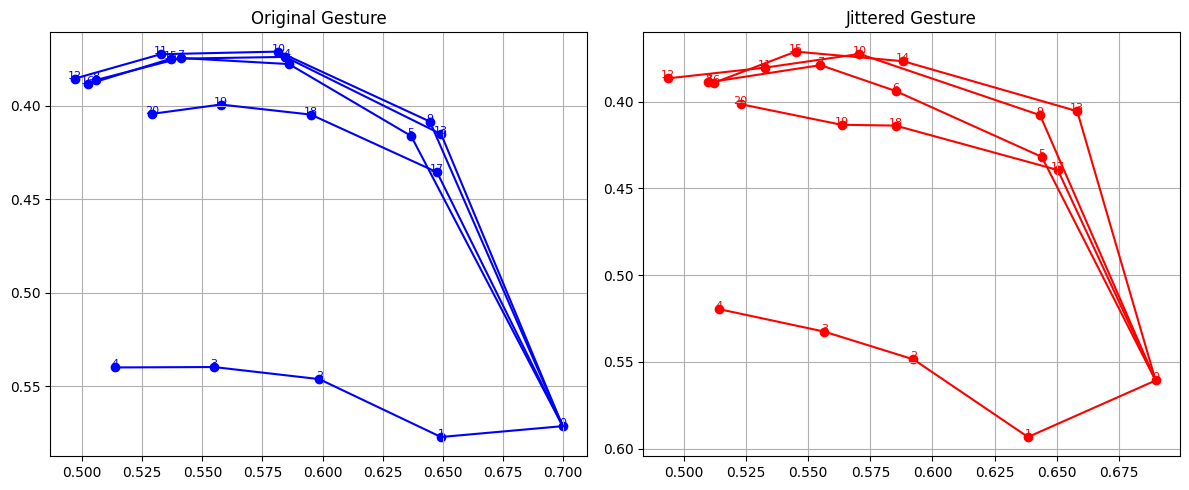

In [41]:
# Koneksi tangan dari MediaPipe (index landmark)
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),       # ibu jari
    (0, 5), (5, 6), (6, 7), (7, 8),       # telunjuk
    (0, 9), (9,10), (10,11), (11,12),     # jari tengah
    (0,13), (13,14), (14,15), (15,16),    # jari manis
    (0,17), (17,18), (18,19), (19,20)     # kelingking
]

# Fungsi jitter
def add_noise(sequence, noise_level=0.01):
    return sequence + np.random.normal(0, noise_level, sequence.shape)

# Load sample
X = np.load("hand_data/aug_SS_data.npy")  # Misalnya shape (n, 10, 63)
sample = X[0]
frame = sample[0]  # frame 1
frame_aug = add_noise(frame.reshape(1, -1)).reshape(-1)

# Ambil koordinat (x, y)
x, y = frame[0::3], frame[1::3]
x_aug, y_aug = frame_aug[0::3], frame_aug[1::3]

# Plot
plt.figure(figsize=(12, 5))

# Sebelum Augmentasi
plt.subplot(1, 2, 1)
plt.title("Original Gesture")
for start, end in HAND_CONNECTIONS:
    plt.plot([x[start], x[end]], [y[start], y[end]], 'b-')  # garis biru
plt.scatter(x, y, c='blue')
for i in range(21):
    plt.text(x[i], y[i], str(i), fontsize=8, color='blue', ha='center')
plt.gca().invert_yaxis()
plt.grid(True)

# Setelah Augmentasi
plt.subplot(1, 2, 2)
plt.title("Jittered Gesture")
for start, end in HAND_CONNECTIONS:
    plt.plot([x_aug[start], x_aug[end]], [y_aug[start], y_aug[end]], 'r-')  # garis merah
plt.scatter(x_aug, y_aug, c='red')
for i in range(21):
    plt.text(x_aug[i], y_aug[i], str(i), fontsize=8, color='red', ha='center')
plt.gca().invert_yaxis()
plt.grid(True)

plt.tight_layout()
plt.show()


# ✅ Load dan preprocessing data, Encode labels and reshape input

In [42]:
import pickle

DATA_DIR = "hand_data"

# Cari semua file data dan label
data_files = [f for f in os.listdir(DATA_DIR) if "X_augmented.npy" in f]
label_files = [f for f in os.listdir(DATA_DIR) if "y_augmented.npy" in f]

# Gabungkan data dan label
X, y = [], []
for file in data_files:
    X.append(np.load(os.path.join(DATA_DIR, file)))  # bentuk (300, 10, 63)
for file in label_files:
    y.append(np.load(os.path.join(DATA_DIR, file)))  # bentuk (300,)

# Gabungkan jadi 1 array
X = np.concatenate(X, axis=0)  # bentuk akhir: (jumlah_total_sample, 10, 63)
y = np.concatenate(y, axis=0)  # bentuk akhir: (jumlah_total_sample,)

# Encode label string ke angka
le = LabelEncoder()
y = le.fit_transform(y)  # Misalnya: ['SS', 'transfer_SS'] -> [0, 1]

# ✅ Simpan LabelEncoder ke file
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
print("LabelEncoder berhasil disimpan ke label_encoder.pkl")

# (Optional) Cek shape dan label unik
print("Shape X:", X.shape)           # (600, 10, 63) misalnya
print("Shape y:", y.shape)
print("Label (encoded):", set(y))    # {0, 1}
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


LabelEncoder berhasil disimpan ke label_encoder.pkl
Shape X: (1800, 10, 63)
Shape y: (1800,)
Label (encoded): {0, 1}
Label mapping: {'SS': 0, 'transfer_SS': 1}


# ✅ Split data + model training + validation

In [43]:
# Split data (dengan stratifikasi label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = Sequential([
    LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2])),  # (10, 63)
    Dense(64, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test, y_test)
)



Epoch 1/30
90/90 [==============================] - 2s 6ms/step - loss: 0.2786 - accuracy: 0.9014 - val_loss: 0.2189 - val_accuracy: 0.9167
Epoch 2/30
90/90 [==============================] - 0s 4ms/step - loss: 0.1078 - accuracy: 0.9639 - val_loss: 0.1219 - val_accuracy: 0.9583
Epoch 3/30
90/90 [==============================] - 0s 4ms/step - loss: 0.0538 - accuracy: 0.9819 - val_loss: 0.0367 - val_accuracy: 0.9833
Epoch 4/30
90/90 [==============================] - 0s 3ms/step - loss: 0.0579 - accuracy: 0.9812 - val_loss: 0.0463 - val_accuracy: 0.9889
Epoch 5/30
90/90 [==============================] - 0s 4ms/step - loss: 0.0393 - accuracy: 0.9889 - val_loss: 0.0314 - val_accuracy: 0.9861
Epoch 6/30
90/90 [==============================] - 0s 4ms/step - loss: 0.0319 - accuracy: 0.9896 - val_loss: 0.0258 - val_accuracy: 0.9889
Epoch 7/30
90/90 [==============================] - 0s 4ms/step - loss: 0.0215 - accuracy: 0.9910 - val_loss: 0.0315 - val_accuracy: 0.9861
Epoch 8/30
90/90 [==

# ✅ Plot accuracy dan loss

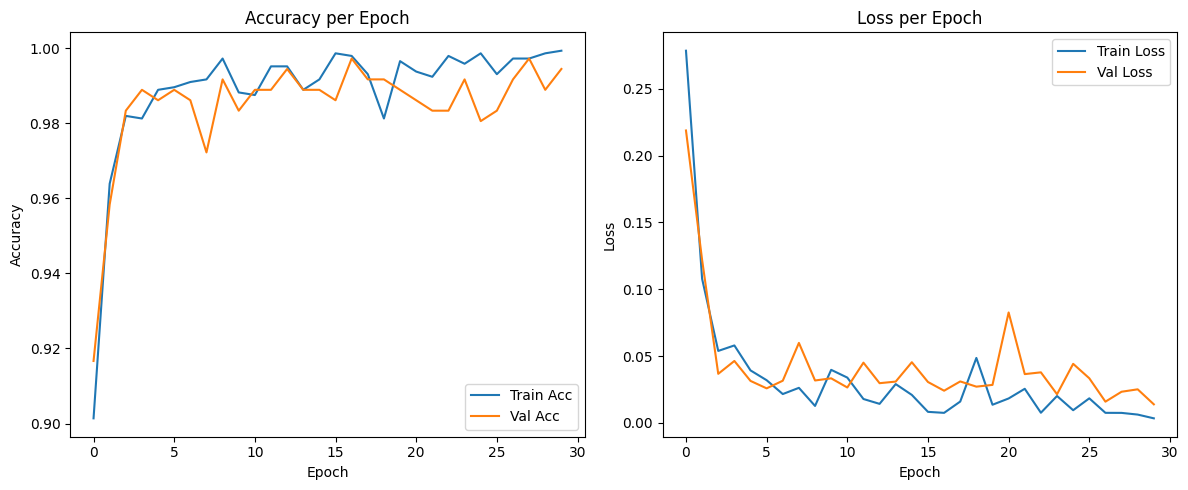

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# ✅ Confusion matrix dan evaluasi model

12/12 [==============================] - 0s 2ms/step


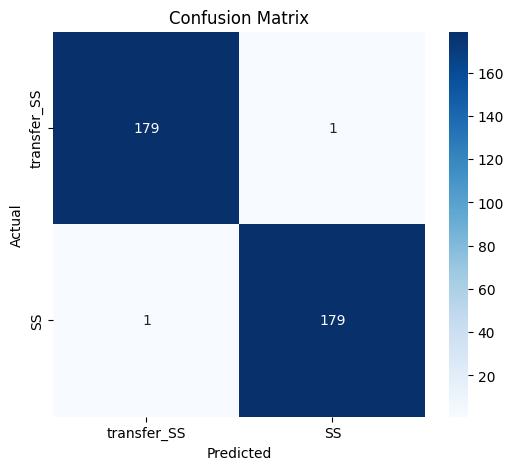

Accuracy: 99.44%
Precision: 99.44%
Recall: 99.44%
F1-score: 99.44%


In [45]:
# Prediksi kelas
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Urutan label yang diinginkan: transfer_SS dulu, lalu SS
label_order = ['transfer_SS', 'SS']

# Ambil indeks label sesuai urutan di LabelEncoder
label_indices = [np.where(le.classes_ == label)[0][0] for label in label_order]

# Hitung confusion matrix dengan urutan label yang diatur
cm = confusion_matrix(y_test, y_pred_classes, labels=label_indices)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_order, yticklabels=label_order)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Hitung classification report dengan label terurut
report = classification_report(y_test, y_pred_classes,
                               labels=label_indices,
                               target_names=label_order,
                               output_dict=True)

# Ambil metrik-metrik utama
accuracy = report['accuracy'] * 100
precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1 = report['weighted avg']['f1-score'] * 100

# Cetak hasil evaluasi
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-score: {f1:.2f}%")

# ✅ Tampilkan metrik dalam format besar HTML

In [46]:
html = f"""
<h3><strong>Accuracy:</strong> {accuracy:.2f}%</h3>
<h3><strong>Precision:</strong> {precision:.2f}%</h3>
<h3><strong>Recall:</strong> {recall:.2f}%</h3>
<h3><strong>F1-score:</strong> {f1:.2f}%</h3>
"""
display(HTML(html))

# ✅ Simpan model

In [47]:
model.save("hand_gesture_model.h5")

d:\Tugas Akhir\Program\jupyter-hands-recognition\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# ✅ Real-time prediksi gesture via webcam

In [2]:

import pickle  # untuk load LabelEncoder

# Load model dan label encoder
model = tf.keras.models.load_model("hand_gesture_model.h5")
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)  # le = LabelEncoder yang sudah fit sebelumnya

# Inisialisasi MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

# Buffer untuk menyimpan 10 frame terakhir
sequence_buffer = []

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb_frame)

    if result.multi_hand_landmarks:
        hand_landmarks = result.multi_hand_landmarks[0]
        landmarks = []
        for lm in hand_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])

        sequence_buffer.append(landmarks)
        sequence_buffer = sequence_buffer[-10:]  # Simpan hanya 10 frame terakhir

        # Jika sudah terkumpul 10 frame, prediksi
        if len(sequence_buffer) == 10:
            input_sequence = np.array(sequence_buffer).reshape(1, 10, 63)  # (1, 10, 63)
            prediction = model.predict(input_sequence, verbose=0)
            class_index = np.argmax(prediction)
            class_label = le.inverse_transform([class_index])[0]

            # Tampilkan hasil prediksi
            cv2.putText(frame, f"Prediksi: {class_label}", (10, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    cv2.imshow("Hand Gesture Recognition", frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
